In [1]:
import math

In [2]:
def get_quota(capital, interes_mensual, nombre_mensualitats):
    """
    """
    try:
        return capital * interes_mensual / (1-(1 + interes_mensual)**(-nombre_mensualitats))
    except Exception as e:
        print 'capital:', capital
        print 'interes_mensual', interes_mensual
        print 'mensualitats', nombre_mensualitats
        assert False

def desglossar_quota(capital, interes_mensual, cuota):
    interessos = capital * interes_mensual
    amortitzat = cuota - interessos
    return amortitzat, interessos

def get_mensualitats(capital, interes_mensual, cuota_objectiu):
    return - int(math.log(1-capital*interes_mensual/cuota_objectiu) / math.log(1+interes_mensual) - 0.00001) + 1


def get_euribor(euribor_inicial, canvis_euribor, mes):

    for m in range(mes, -1, -1):
        if m in canvis_euribor:

            return canvis_euribor[m]
    return euribor_inicial
            
def get_amortitzacio(amortitzacions, mes):
    if mes in amortitzacions:
        return amortitzacions[mes]
    return {'import': 0., 'tipus': 'quota'}

def simular_hipoteca(capital_inicial, euribor_inicial, diferencial, mensualitats, amortitzacions=[], canvis_euribor=[]):
    """
    amortitzacions es un diccionari. Les claus son els mesos on hi ha amortització
                                     i te com a valor un diccionari amb entrades "import" i "tipus".
    canvis euribor es un diccionari amb clau el mes i valor el canvi.
    """
    deute = capital_inicial 
    resultat = []
    mes = 1
    euribor = euribor_inicial
    interes_mensual = (euribor_inicial + diferencial) / 12
    cuota_previa = None
    limit = 580
    mensualitats_pendents = mensualitats
    while deute > 0 and mensualitats_pendents > 0:
        
        
        if mes > limit:
            break
        line = {}
        # Generem una linea: mes
        line['mes'] = mes
        # recalcular interes si hi ha canvi d'euribor
        euribor = get_euribor(euribor_inicial, canvis_euribor, mes)
        line['euribor'] = euribor
        line['diferencial'] = diferencial
        line['interes_mensual'] = (euribor + diferencial) / 12
        cuota = get_quota(deute, line['interes_mensual'], mensualitats_pendents)
        
        cuota_interessos = deute * line['interes_mensual']
        cuota_amortitzacio = cuota - cuota_interessos
        line['deute'] = deute
        line['cuota'] = cuota
        line['cuota_interessos'] = cuota_interessos
        line['cuota_amortitzacio'] = cuota_amortitzacio
        
        deute = deute - line['cuota_amortitzacio']
        line['mensualitats_pendents'] = mensualitats_pendents - 1
         
        
        # restar amortitzacio si n'hi ha.
        amortitzacio = get_amortitzacio(amortitzacions, mes)
        # si amortitzacio
        if amortitzacio['import'] > 0:
            deute = deute - amortitzacio['import']
        
        if amortitzacio['tipus'] == 'temps':
            mensualitats_pendents = get_mensualitats(deute, line['interes_mensual'], cuota)
        
        
        line['import_amortitzat'] = amortitzacio['import']
            
        mes += 1
        mensualitats_pendents += -1
        resultat.append(line)
        
    return resultat
    
    

In [13]:
CAPITAL_INICIAL = 100000.0
EURIBOR_INICIAL = -0.012/100
DIFERENCIAL = 0.8 / 100
MENSUALITATS = 480

canvis_euribor = {
    12: -0.127 / 100,
    #24: 0.01,
    #36: 0.02,
    #48: 0.05,
    #60: 0.04,
    #84: 0.03
}
amortitzacions = {
    12:{'import':13500, 'tipus': 'cuota'},
    24: {'import':3000, 'tipus': 'temps'},
    #36: {'import':3000, 'tipus': 'cuota'},
    #48: {'import':3000, 'tipus': 'cuota'},
    #60: {'import':0, 'tipus': 'cuota'},
    #72: {'import':0, 'tipus': 'cuota'},
    
}
resultat = simular_hipoteca(CAPITAL_INICIAL, EURIBOR_INICIAL, DIFERENCIAL, MENSUALITATS, amortitzacions=amortitzacions, canvis_euribor=canvis_euribor)

In [14]:
len(resultat)
total_interessos = sum([l['cuota_interessos'] for l in resultat])
total_pagat = sum([l['cuota'] for l in resultat])
print 'Total pagat:', total_pagat
print 'Interessos totals:', total_interessos

Total pagat: 94989.826679
Interessos totals: 11489.826679


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


<Container object of 461 artists>

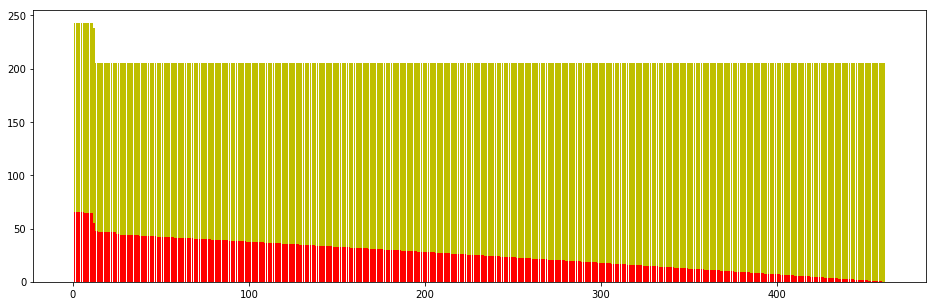

In [16]:
interessos = [l['cuota_interessos'] for l in resultat]
amortitzacions = [l['cuota_amortitzacio'] for l in resultat]
mesos = [l['mes'] for l in resultat]
fig = plt.figure(figsize=(16,5))
plt.bar(mesos, interessos, color='r', edgecolor = "none")
plt.bar(mesos, amortitzacions, bottom=interessos, color='y',edgecolor = "none")


In [8]:
resultat[0]

{'cuota': 242.9564937834504,
 'cuota_amortitzacio': 177.28982711678375,
 'cuota_interessos': 65.66666666666666,
 'deute': 100000.0,
 'diferencial': 0.008,
 'euribor': -0.00012,
 'import_amortitzat': 0.0,
 'interes_mensual': 0.0006566666666666666,
 'mensualitats_pendents': 479,
 'mes': 1}